In [1]:
%load_ext autoreload
%autoreload 2

# Burger equation

Comparison of DeepXDE and Jinns performance on the Burger equation 


## DeepXDE
Example taken from : https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html

We use the JAX backend.

In [2]:
seed = 1234

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Compiling model...


2024-10-25 16:47:16.296839: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


'compile' took 1.537545 s

Training model...

Traced<ShapedArray(float32[3074,1])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[3074,1])>with<DynamicJaxprTrace(level=1/0)>
Step      Train loss                        Test loss                         Test metric
0         [1.68e-01, 2.07e-01, 2.91e-01]    [1.68e-01, 2.07e-01, 2.91e-01]    []  
1000      [4.25e-02, 8.90e-04, 5.79e-02]    [4.25e-02, 8.90e-04, 5.79e-02]    []  
2000      [3.20e-02, 1.87e-04, 4.84e-02]    [3.20e-02, 1.87e-04, 4.84e-02]    []  
3000      [1.89e-02, 1.88e-04, 2.87e-02]    [1.89e-02, 1.88e-04, 2.87e-02]    []  
4000      [9.51e-03, 9.05e-05, 9.03e-03]    [9.51e-03, 9.05e-05, 9.03e-03]    []  
5000      [5.28e-03, 4.21e-05, 2.92e-03]    [5.28e-03, 4.21e-05, 2.92e-03]    []  
6000      [3.20e-03, 2.49e-05, 1.75e-03]    [3.20e-03, 2.49e-05, 1.75e-03]    []  
7000      [2.27e-03, 1.37e-05, 1.45e-03]    [2.27e-03, 1.37e-05, 1.45e-03]    []  
8000      [2.45e-03, 1.03e-05, 1.30e-03]    [2.45e-03, 1.0

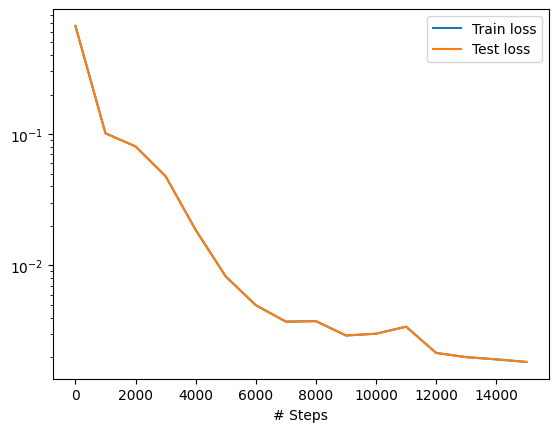

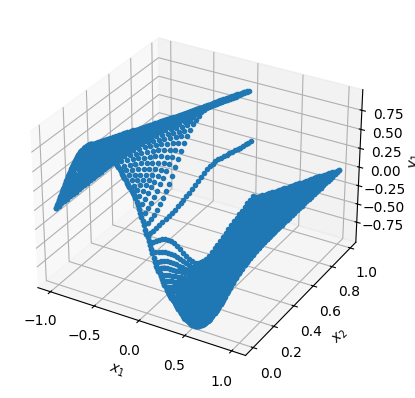

Traced<ShapedArray(float32[25600,1])>with<DynamicJaxprTrace(level=1/0)>
Mean residual: 0.099579334
L2 relative error: 0.14707443939887452


In [3]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import os
os.environ["DDE_BACKEND"]="jax"
import deepxde as dde
import numpy as np

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(seed)


def gen_testdata():
    data = np.load("../dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


def pde(x, y):
    y_val, y_fn = y
    print(y_val)
    dy_x, _ = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t, _ = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx, _ = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y_val * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160, train_distribution="uniform"
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=15000)
# Not sure how to do this in JAX
# model.compile("L-BFGS")
# losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [4]:
2592+240

2832

In [5]:
data.train_points().shape

(2832, 2)

## With Jinns

In [6]:
import jax
import equinox as eqx
import jinns
import jax.numpy as jnp
from jax import grad, vmap, random
import optax
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(seed)

In [7]:
eqx_list = (
    (eqx.nn.Linear, 2, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1)
)
key, subkey = random.split(key)
u_pinn, init_nn_params_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [8]:
n = 2540 # data.num_domain
ni = 160 # data.num_initial
nb = 80 # data.num_boundary
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 0.99
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [9]:
# create Burger loss
nu = 1 / (100 * jnp.pi)


In [10]:
# Init parameters for NN and equation
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "nu":nu
    }
)

In [11]:

be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)

def u0(x):
    return -jnp.sin(jnp.pi * x)

loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1, boundary_loss=1
)

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t_dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
    params=init_params_pinn,
)

In [12]:
# Training loop in Jinns
params_pinn = init_params_pinn
tx = optax.adam(learning_rate=1e-3)
n_iter = 15000

In [13]:
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
    verbose=True
)

Compilation took 3.037964105606079
[train] Iteration 0: loss value = 0.6634801626205444
[train] Iteration 1000: loss value = 0.10743191838264465
[train] Iteration 2000: loss value = 0.05284085497260094
[train] Iteration 3000: loss value = 0.018889687955379486
[train] Iteration 4000: loss value = 0.010531686246395111
[train] Iteration 5000: loss value = 0.006897313520312309
[train] Iteration 6000: loss value = 0.004932347685098648
[train] Iteration 7000: loss value = 0.004133619833737612
[train] Iteration 8000: loss value = 0.003192721866071224
[train] Iteration 9000: loss value = 0.002601487794891
[train] Iteration 10000: loss value = 0.002274023136124015
[train] Iteration 11000: loss value = 0.002057986333966255
[train] Iteration 12000: loss value = 0.0018139851745218039
[train] Iteration 13000: loss value = 0.0016422092448920012
[train] Iteration 14000: loss value = 0.0015072266105562449
Stopping main optimization loop, cause: max iteration is reached
Training took 19.383245706558228

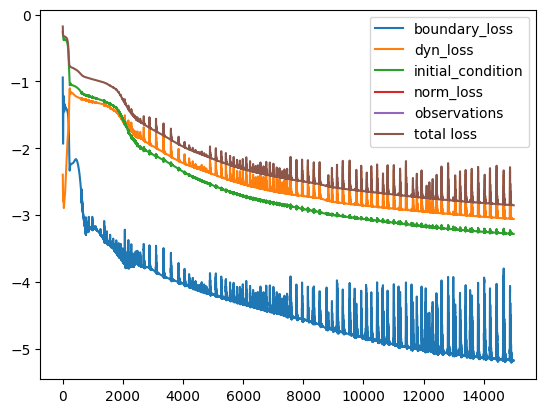

In [14]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

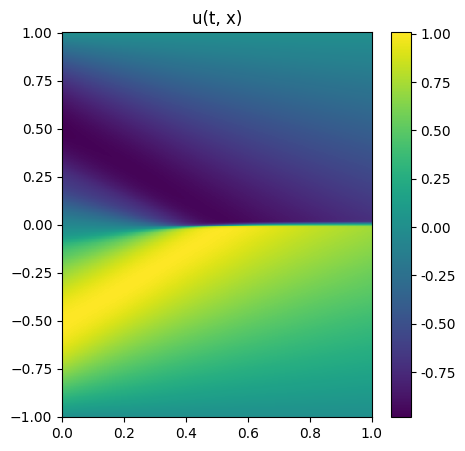

In [15]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

u_est_pinn = lambda t_x:u_pinn(t_x, params_pinn)
# same subkey
jinns.plot.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

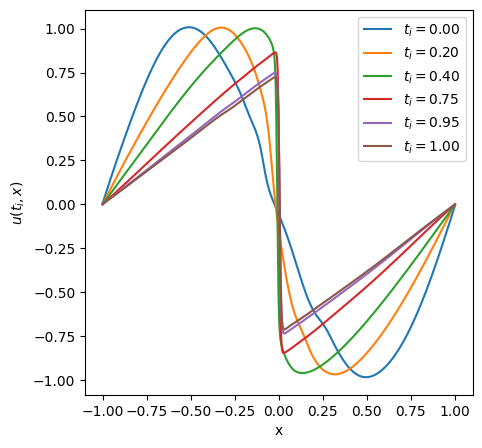

In [16]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.plot.plot1d_slice(u_est_pinn, xdata=val_xdata, time_slices=time_slices,  figsize=(5, 5))

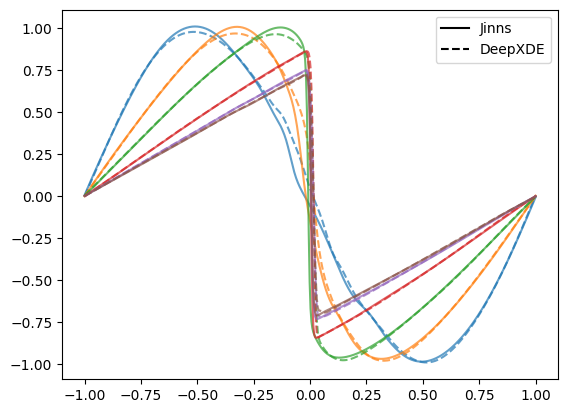

In [17]:
from functools import partial

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
diffs = []
for i, ti in enumerate(time_slices):
    val_ti = jnp.column_stack([val_xdata, jnp.repeat(ti, nx)])
    val_ti_normalized = jnp.column_stack([jnp.repeat(ti, nx) / Tmax, val_xdata, ])
    u_est_tfixed = vmap(u_est_pinn)#vmap(partial(u_est_pinn, t=ti * jnp.ones((1,)) / Tmax), 0, 0)
    plt.plot(val_xdata, model.predict(x=val_ti), label=rf"$DDE: t_i = {ti}$", linestyle="--", alpha=.7, color = cycle[i])
    plt.plot(val_xdata, u_est_tfixed(val_ti_normalized), label=rf"$Jinns:  t_i = {ti}$", alpha=.7, color = cycle[i])
    diffs.append(jnp.abs(u_est_tfixed(val_ti_normalized) - model.predict(x=val_ti)))

    # plt.plot(val_xdata, u_est_tfixed(x=val_xdata[:, None]), label=rf"$Jinns:  t_i = {ti}$", alpha=.7, color = cycle[i])
    # diffs.append(jnp.abs(u_est_tfixed(x=val_xdata[:, None]) - model.predict(x=val_ti)))

from matplotlib.lines import Line2D
line_jinns = Line2D([0], [0], label='Jinns', color='black',linestyle="-")
line_dde = Line2D([0], [0], label='DeepXDE', color='black', linestyle="--")
plt.legend(handles=[line_jinns, line_dde])

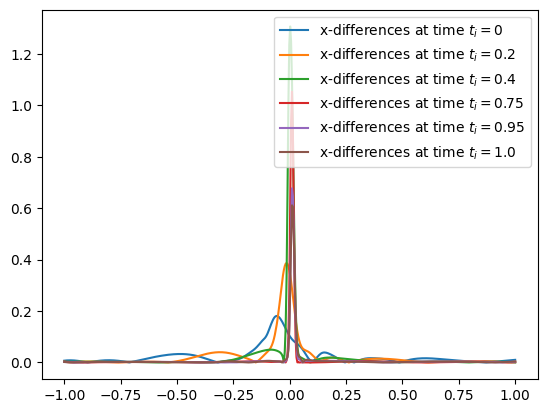

In [18]:
for dif, ti in zip(diffs, time_slices):
    plt.plot(val_xdata, dif, label=rf"x-differences at time $t_i={ti}$")
plt.legend()

In [19]:
len(diffs)

6